In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import backtrader as bt # Import the backtrader platform
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import seaborn as sns

# 1. Training (From 2000-01-01 to 2013-08-13)

In [4]:
# Load data
df = pd.read_csv("../data/SPX.csv")
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")
Price = df.loc["2000-01-01":"2018-01-01","Adj Close"]
Volume = df.loc["2000-01-01":"2018-01-01","Volume"]

In [5]:
def compute_bollinger_band(series=Price, bb_window=20, num_std=1):
    bollinger_band_middle = series.rolling(window = bb_window).mean()
    rolling_std = series.rolling(window = bb_window).std()
    bollinger_band_upper = bollinger_band_middle+rolling_std*num_std
    bollinger_band_lower = bollinger_band_middle-rolling_std*num_std
    return bollinger_band_upper,bollinger_band_middle, bollinger_band_lower

In [6]:
def momentum_strategy0(series=Price, ma_window=5):
    ma = series.rolling(window = ma_window).mean()
    position = pd.Series(None,index = series.index)
    # long if asset crosses over ma_window-bar moving average 
    long = (series.shift() < ma.shift()) & (series > ma)
    # short if asset crosses down below ma_window-bar moving average 
    short = (series.shift() > ma.shift()) & (series < ma)
    
    position.loc[long] = +1
    position.loc[short] = -1

    position.fillna(method="ffill",inplace=True)
    position.fillna(0,inplace=True)
    return position.astype(np.int)

In [7]:
def momentum_strategy(series=Price, bb_window=25, num_std=1.2):
    bb_upper, bb_middle, bb_lower = compute_bollinger_band(series, bb_window, num_std)
    position = pd.Series(None,index = series.index)
    
    # Long if asset crosses over Upper Band
    long = series>=bb_upper

    # Short if asset crosses down Lower Band
    short = series<=bb_lower
    
    position.loc[short] = -1
    position.loc[long] = +1
    
    open_position = position.fillna(method="ffill")
    # close short positon if asset crosses under Middle Band
    close_short = ( (series.shift()<=bb_middle.shift())&(series>bb_middle)&(np.allclose(open_position,+1)) )
    
    # close long positon if asset crosses from below Middle Band
    close_long = ( (series.shift()>=bb_middle.shift())&(series<bb_middle)&(np.allclose(open_position,-1)) )
    
    position.loc[close_short | close_long] = 0
    position.fillna(method="ffill",inplace=True)
    position.fillna(0,inplace=True)
    return position.astype(np.int)

In [8]:
def mean_reversion_strategy(series=Price, bb_window=15, num_std=1):
    bb_upper, bb_middle, bb_lower = compute_bollinger_band(series, bb_window, num_std)
    position = pd.Series(None,index = series.index)
    
    # short if asset crosses over Upper Band
    short = series>=bb_upper
    
    # long if asset crosses down Lower Band
    long = series<=bb_lower

    position.loc[short] = -1
    position.loc[long] = +1
    
    open_position = position.fillna(method="ffill")
    # close short positon if asset crosses under Middle Band
    close_short = ( (series.shift()>=bb_middle.shift())&(series<bb_middle)&(np.allclose(open_position,-1)) )
    # close long positon if asset crosses from below Middle Band
    close_long = ( (series.shift()<=bb_middle.shift())&(series>bb_middle)&(np.allclose(open_position,+1)) )
    
    position.loc[close_short | close_long] = 0
    position.fillna(method="ffill",inplace=True)
    position.fillna(0,inplace=True)
    return position.astype(np.int)

In [9]:
def mean_reversion_strategy(series=Price, bb_window=15, num_std=1):
    bb_upper, bb_middle, bb_lower = compute_bollinger_band(series, bb_window, num_std)
    position = pd.Series(None,index = series.index)
    
    # short if asset crosses over Upper Band
    short = series>=bb_upper
    
    # long if asset crosses down Lower Band
    long = series<=bb_lower

    position.loc[short] = -1
    position.loc[long] = +1
    
    open_position = position.fillna(method="ffill")
    # close short positon if asset crosses under Middle Band
    close_short = ( (series.shift()>=bb_middle.shift())&(series<bb_middle)&(np.allclose(open_position,-1)) )
    # close long positon if asset crosses from below Middle Band
    close_long = ( (series.shift()<=bb_middle.shift())&(series>bb_middle)&(np.allclose(open_position,+1)) )
    
    position.loc[close_short | close_long] = 0
    position.fillna(method="ffill",inplace=True)
    position.fillna(0,inplace=True)
    return position.astype(np.int)

In [10]:
def compute_PNL(price = Price, position=None, reinvest = False):
    return_rate = price.shift(-1)/price - 1
    if reinvest:
        wealth_change = (1+position*return_rate)
        PNL = wealth_change.cumprod()
    else:
        PNL = (position*return_rate).cumsum()
    return PNL

In [11]:
def compute_frequency(position):
    """ Compute the frequency of openning position
    """
    return sum([1 for x in position.diff().dropna() if not np.allclose(x,0)])/2/len(position_mean_reversion)

In [12]:
########################################################
# Set the mean_reversion_strategy and momentum_strategy#
########################################################
# parameters for strategies:
bb_window_mr = 10
num_std_mr = 0.1
bb_window_mo = 29
num_std_mo = 1.3
# strategies:
compute_position_mr = lambda series: mean_reversion_strategy(series=series, bb_window=bb_window_mr, num_std=num_std_mr)
compute_position_mo = lambda series: momentum_strategy(series=series, bb_window=bb_window_mo, num_std=num_std_mo)

In [13]:
########################################################
# Set the mean_reversion_strategy and momentum_strategy#
########################################################
# parameters for strategies:
bb_window_mr = 10
num_std_mr = 0.1
bb_window_mo = 29
num_std_mo = 1.3
# strategies:
compute_position_mr = lambda series: mean_reversion_strategy(series=series, bb_window=bb_window_mr, num_std=num_std_mr)
compute_position_mo = lambda series: momentum_strategy(series=series, bb_window=bb_window_mo, num_std=num_std_mo)

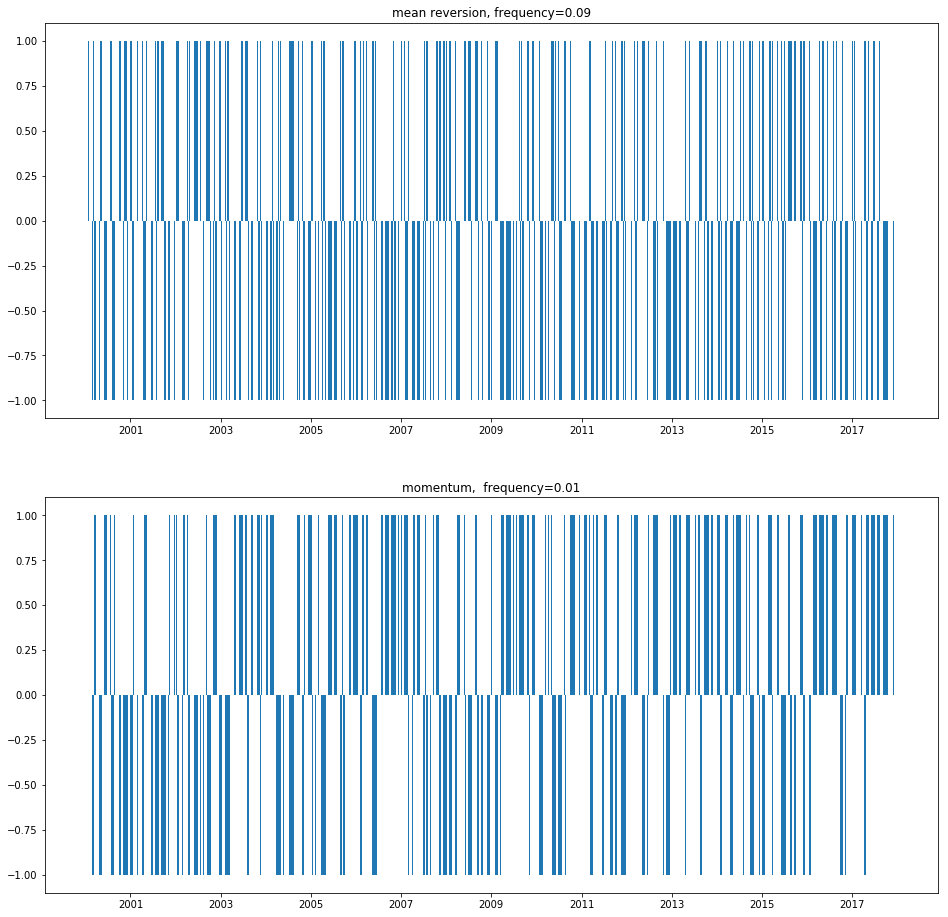

In [14]:
position_mean_reversion = compute_position_mr(series=Price)
position_momentum = compute_position_mo(series=Price)
fig,ax = plt.subplots(2,1,figsize=(16,16))
ax[0].bar(position_mean_reversion.index,position_mean_reversion.values)
ax[0].set_title("mean reversion, frequency=%.2f"%compute_frequency(position_mean_reversion))


ax[1].bar(position_mean_reversion.index,position_momentum.values)
ax[1].set_title("momentum,  frequency=%.2f"%compute_frequency(position_momentum))
plt.show()

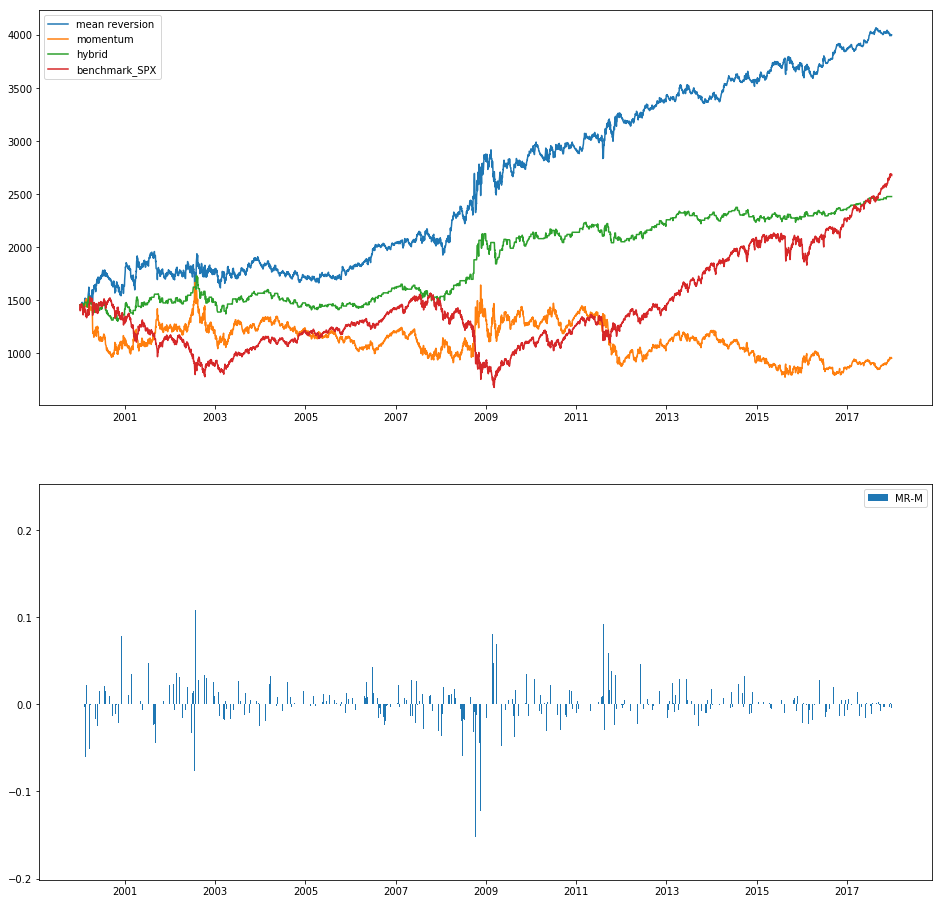

In [15]:
fig, axs = plt.subplots(2,1,figsize=(16,16))
PNL_mean_reversion = compute_PNL(price = Price, position=position_mean_reversion)
PNL_momentum = compute_PNL(price = Price, position=position_momentum)
axs[0].plot(Price[0]*(1+PNL_mean_reversion), label="mean reversion")
axs[0].plot(Price[0]*(1+PNL_momentum), label="momentum")
axs[0].plot(Price[0]*(1+PNL_momentum/2+PNL_mean_reversion/2), label="hybrid")
axs[0].plot(Price,label="benchmark_SPX")
axs[0].legend()
diff_pnl_mr_m = (PNL_mean_reversion.diff()-PNL_momentum.diff()).dropna()
axs[1].bar(diff_pnl_mr_m.index,diff_pnl_mr_m,label="MR-M")
axs[1].legend()
plt.show()

## Collect Data

In [13]:
def compute_hurst_exponent(arr):
    num_lag = 18
    lag_arr = np.arange(2,2+num_lag)
    tau_arr = np.zeros(num_lag)
    #  Step through the different lags
    for i in range(num_lag):
        lag = lag_arr[i]
        #  produce price difference with lag
        arr_diff = np.diff(arr,lag)
        #  Calculate the variance of the differnce vector
        tau_arr[i] = np.sqrt(np.std(arr_diff))
    #  linear fit to double-log graph (gives power)
    m = np.polyfit(np.log10(lag_arr),np.log10(tau_arr),1)
    # calculate hurst
    hurst = m[0]*2
    return hurst

def compute_vol(arr):
    log_arr = np.log(arr)
    return_arr = np.diff(log_arr)
    vol = np.float(np.sqrt(np.cov(return_arr)))
    return vol

def compute_long_short_scale_vol_ratio(arr, long_scale ,short_scale=1):
    arr_long_scale = arr[::long_scale]
    arr_short_scale = arr[::short_scale]
    
    return compute_vol(arr_short_scale)/compute_vol(arr_long_scale)

def compute_autocorr(arr, lag):
    log_arr = np.log(arr)
    return_arr = np.diff(log_arr)
    mat_autocov = np.cov(return_arr[lag:],return_arr[:-lag])
    autocorr = mat_autocov[1,0]/np.sqrt(mat_autocov[0,0]*mat_autocov[1,1])
    return autocorr

def compute_sharpe(arr):
    ret = np.divide(np.diff(arr),arr[:-1])
    return(np.mean(ret)/np.std(ret))

In [14]:
window_indicators = 30
Indicators = pd.DataFrame(index = Price.index, columns=["hurst_exponent",
                                                        "long_short_scale_vol_ratio_2",
                                                        "long_short_scale_vol_ratio_3",
                                                        "long_short_scale_vol_ratio_4",
                                                        "long_short_scale_vol_ratio_5",
                                                        "autocorr_1",
                                                        "autocorr_2",
                                                        "autocorr_3",
                                                        "autocorr_4",
                                                        "autocorr_5",
                                                        "autocorr_6",
                                                        "autocorr_7",
                                                        "sharpe_ratio",
                                                        "PVT",
                                                        "Volume"])
Indicators.loc[:,"hurst_exponent"] = Price.rolling(window=window_indicators).apply(compute_hurst_exponent)
Indicators.loc[:,"long_short_scale_vol_ratio_2"] = Price.rolling(window=window_indicators).apply(lambda x:compute_long_short_scale_vol_ratio(x,2))
Indicators.loc[:,"long_short_scale_vol_ratio_3"] = Price.rolling(window=window_indicators).apply(lambda x:compute_long_short_scale_vol_ratio(x,3))
Indicators.loc[:,"long_short_scale_vol_ratio_4"] = Price.rolling(window=window_indicators).apply(lambda x:compute_long_short_scale_vol_ratio(x,4))
Indicators.loc[:,"long_short_scale_vol_ratio_5"] = Price.rolling(window=window_indicators).apply(lambda x:compute_long_short_scale_vol_ratio(x,5))
Indicators.loc[:,"autocorr_1"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,1))
Indicators.loc[:,"autocorr_2"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,2))
Indicators.loc[:,"autocorr_3"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,3))
Indicators.loc[:,"autocorr_4"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,4))
Indicators.loc[:,"autocorr_5"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,5))
Indicators.loc[:,"autocorr_6"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,6))
Indicators.loc[:,"autocorr_7"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,7))
Indicators.loc[:,"sharpe_ratio"] = Price.rolling(window=window_indicators).apply(compute_sharpe)
Indicators.loc[:,"PVT"] = ((Price/Price.diff()-1)*Volume/1e10).rolling(window=10).mean()
Indicators.loc[:,"Volume"] = Volume
Indicators.loc[:,"Price"] = Price


df_dropna = Indicators.dropna()

### 1.2 Constructing Training Set and Test Set

In [113]:
# Parameters
window_lookback = 3
window_prediction = 9
num_features = 15

In [114]:
# Feature
df_dropna = df_dropna.iloc[:,:num_features].dropna()
X = np.zeros((len(df_dropna.index),num_features*window_lookback))
idx_X = [None]*X.shape[0]
for i in range(window_lookback-1,len(df_dropna.index)):
    # transform the feature matrix for a certain window into a vector
    X[i,:] = df_dropna.iloc[i-window_lookback+1:i+1,:num_features].values.reshape(1,-1)
    idx_X[i] = df_dropna.index[i]
X = pd.DataFrame(X[window_lookback-1:],index=idx_X[window_lookback-1:])

In [115]:
# Label
y = diff_pnl_mr_m.rolling(window=window_prediction).mean().shift(-window_prediction+1).dropna()
PNL_mean_reversion = compute_PNL(price = Price, position=position_mean_reversion)
PNL_momentum = compute_PNL(price = Price, position=position_momentum)
y = y.reindex(df_dropna.index)

In [116]:
# Align the Features and Labels
# index
idx = X.index.intersection(y.index)
# Feature
X = X.loc[idx,:]
# Label
y = y.loc[idx]
y_class = pd.Series(0,index = y.index,dtype=int)
y_class[y>=0.001] =+1
y_class[y.abs()<0.001] =0
y_class[y<=-0.001] =-1

In [117]:
# split to train and test
X_train, X_test = X["2000-01-01":"2013-08-13"], X["2013-08-14":]
y_train, y_test = y_class["2000-01-01":"2013-08-13"], y_class["2013-08-14":]

## Train Random Forest

In [118]:
# Use Random Forest
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500,max_leaf_nodes=16,n_jobs=-1)
rnd_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [119]:
# Train
rnd_clf.fit(X_train, y_train)
train_score = rnd_clf.score(X_train, y_train)
print("Accuracy in train set: %.4f%%"%(train_score*100))

Accuracy in train set: 58.5236%


In [120]:
# Test
test_score = rnd_clf.score(X_test, y_test)
print("Accuracy in test set: %.4f%%"%(test_score*100))

Accuracy in test set: 43.3272%


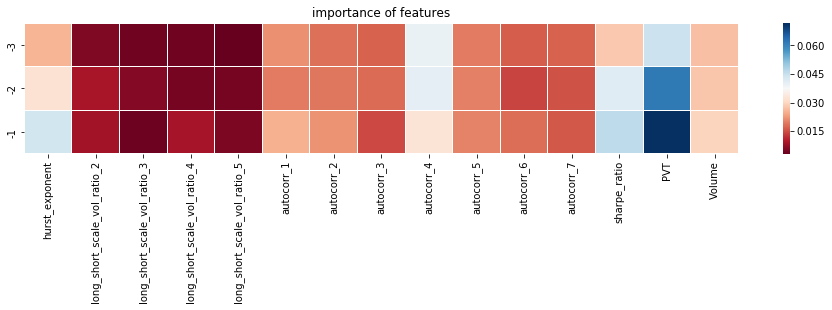

In [133]:
# Plot the importance heatmap
impt = rnd_clf.feature_importances_.reshape(window_lookback,num_features)
impt = pd.DataFrame(impt,index=-1*np.arange(window_lookback,0,-1),columns=Indicators.columns[:num_features])
f, ax= plt.subplots(figsize = (16, 2.4))
sns.heatmap(impt, vmin=impt.values.min(), vmax=impt.values.max(),cmap="RdBu", linewidths = 0.05, ax = ax)
ax.set_title("importance of features")
plt.show()

# Back Test (From 2013-08-13 to 2018-01-01) with my backtest

In [122]:
# Load test data
df = pd.read_csv("../data/SPX.csv")
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")
Price = df.loc["2013-08-13":"2018-01-01","Adj Close"]
Volume = df.loc["2013-08-13":"2018-01-01","Volume"]

In [123]:
# switch regime by equally voting
window_voting = 5
rm_over_m = pd.Series(rnd_clf.predict(X_test)).fillna(0)
rm_over_m = pd.Series([1 if x else 0 for x in rm_over_m.rolling(window=window_voting).sum()>=0],index=X_test.index)

In [124]:
# switch regime by exponential voting
window_voting = 15
rm_over_m = pd.Series(rnd_clf.predict(X_test)).fillna(0)
rm_over_m = pd.Series([1 if x else 0 for x in rm_over_m.ewm(com=0.5).mean()>=0],index=X_test.index)

In [125]:
position_mean_reversion = compute_position_mr(series=Price)
position_momentum = compute_position_mo(series=Price)
position_half_hybrid = (position_mean_reversion+position_momentum)/2
position_regime_switching = (position_mean_reversion*rm_over_m+position_momentum*(1-rm_over_m))

In [126]:
# Partially Distributed position
prob_rm_over_m = pd.DataFrame(rnd_clf.predict_proba(X_test),index=X_test.index).fillna(0)
position_partial_distribution= (position_mean_reversion*(prob_rm_over_m.iloc[:,0]+0.5*prob_rm_over_m.iloc[:,1])+
                               position_momentum*(prob_rm_over_m.iloc[:,1]+0.5*prob_rm_over_m.iloc[:,1]))

In [127]:
pnl_mean_reversion = compute_PNL(price = Price, position=position_mean_reversion)
pnl_momentum = compute_PNL(price = Price, position=position_momentum)
pnl_half_hybrid = compute_PNL(price = Price, position=position_half_hybrid)
pnl_regime_switching = compute_PNL(price = Price, position=position_regime_switching)
pnl_partial_distribution = compute_PNL(price = Price, position=position_partial_distribution)

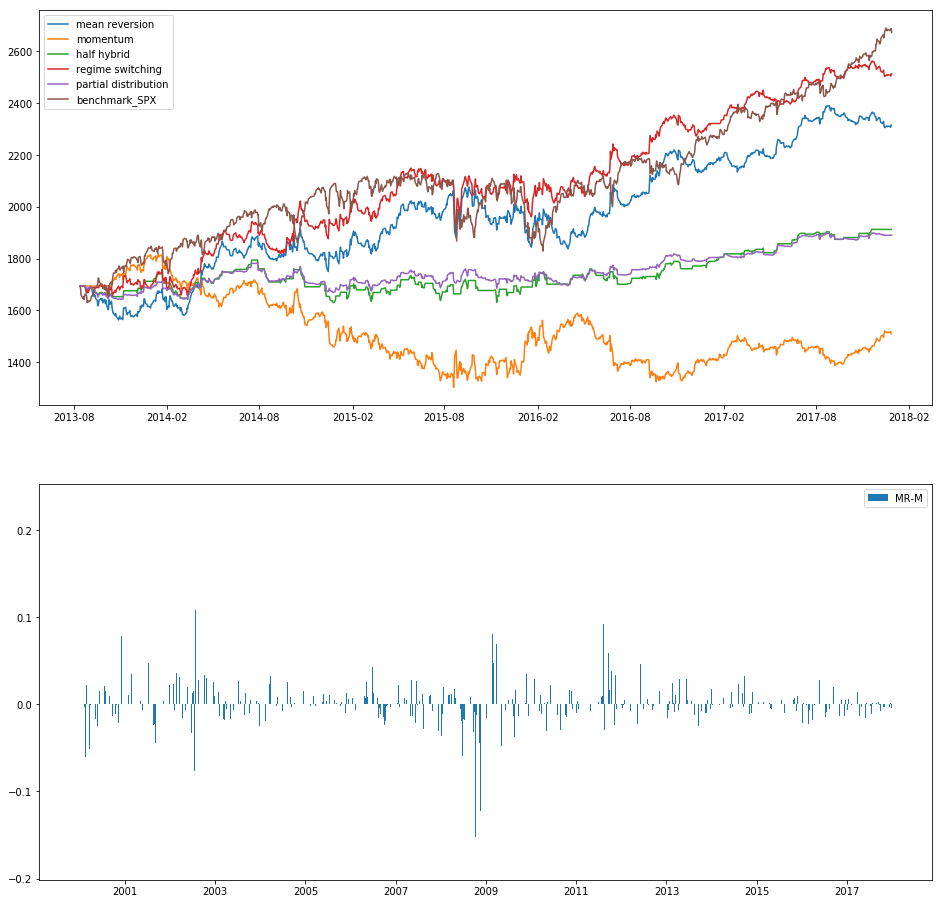

In [128]:
fig, axs = plt.subplots(2,1,figsize=(16,16))

idx_test = X_test.index

axs[0].plot(Price[0]*(1+pnl_mean_reversion), label="mean reversion")
axs[0].plot(Price[0]*(1+pnl_momentum), label="momentum")
axs[0].plot(Price[0]*(1+pnl_half_hybrid), label="half hybrid")
axs[0].plot(Price[0]*(1+pnl_regime_switching.ffill()), label="regime switching")
axs[0].plot(Price[0]*(1+pnl_partial_distribution.ffill()), label="partial distribution")
axs[0].plot(Price,label="benchmark_SPX")
axs[0].legend()
diff_pnl_mr_m = (PNL_mean_reversion.diff()-PNL_momentum.diff()).dropna()
axs[1].bar(diff_pnl_mr_m.index,diff_pnl_mr_m,label="MR-M")
axs[1].legend()
plt.show()

# Back Test (From 2013-08-13 to 2018-02-09) with backtrader [Not Finished]

## Momentum Strategy
Momentum(period_BB,num_std):        
* Long if asset crosses over Upper Band         
-close if asset crosses under Middle Band       
* Short if asset crosses down Lower Band        
-close if asset crosses from below Middle Band 

In [31]:
help(bt.Strategy.position)

Help on property:

    Returns the current position for a given data in a given broker.
    
    If both are None, the main data and the default broker will be used
    
    A property ``position`` is also available



In [32]:
# Create a Stratey
class MomentumStrategy(bt.Strategy):
    params = (
        ('period_BB', 15),
        ('devfactor', 1.2),
        ('movav', bt.indicators.SimpleMovingAverage)
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        
        
        # Add a MovingAverageSimple indicator
        self.midband = ma = self.params.movav(self.datas[0], period=self.params.period_BB)
        stddev = self.params.devfactor * bt.indicators.StdDev(self.datas[0], ma, period=self.params.period_BB,
                                           movav=self.params.movav)
        self.topband = ma + stddev
        self.botband = ma - stddev
        
        # To keep track of pending orders
        self.order = None
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f ; Position %f' % (self.dataclose[0],self.position.size))
        
        

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            #Open position

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] >= self.topband[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

            if self.dataclose[0] <= self.botband[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

        #Exit position
        elif self.position.size>0:
            #Exit the long position
            if self.dataclose[0] <= self.midband[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('[Exit]SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
                
        elif self.position.size<0:
            #Exit the short position
            if self.dataclose[0] >= self.midband[0]:
                
                self.log('[Exit]BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()


## Mean-Reversion Strategy
Momentum(period_MA):
* long if asset crosses over period_MA-bar moving average             
-close if asset crosses under period_MA-bar moving average       
* short if asset crosses down below period_MA-bar moving average         
-close if asset crosses from below period_MA-bar moving average  

In [18]:
# Create a Stratey
class MeanReversionStrategy(bt.Strategy):
    params = (
        ('period_BB', 15),
        ('devfactor', 1.2),
        ('movav', bt.indicators.SimpleMovingAverage)
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        
        
        # Add a MovingAverageSimple indicator
        self.midband = ma = self.params.movav(self.datas[0], period=self.params.period_BB)
        stddev = self.params.devfactor * bt.indicators.StdDev(self.datas[0], ma, period=self.params.period_BB,
                                           movav=self.params.movav)
        self.topband = ma + stddev
        self.botband = ma - stddev
        
        # To keep track of pending orders
        self.order = None
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None


    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f ; Position %f' % (self.dataclose[0],self.position.size))
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            #Open position

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] <= self.botband[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

            if self.dataclose[0] >= self.topband[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

        #Exit position
        elif self.position.size>0:
            #Exit the long position
            if self.dataclose[0] > self.midband[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('[Exit]SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
                
        elif self.position.size<0:
            #Exit the short position
            if self.dataclose[0] < self.midband[0]:
                
                self.log('[Exit]BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()


In [18]:
# Create a Stratey
class AStrategy(bt.Strategy):
    params = (
        ('period_BB', 15),
        ('devfactor', 1.2),
        ('movav', bt.indicators.SimpleMovingAverage)
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].date
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None


    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f ; Position %f' % (self.dataclose[0],self.dataclose[0],self.position.size))
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            #Open position

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] <= self.botband[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

            if self.dataclose[0] >= self.topband[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

        #Exit position
        elif self.position.size>0:
            #Exit the long position
            if self.dataclose[0] > self.midband[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('[Exit]SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
                
        elif self.position.size<0:
            #Exit the short position
            if self.dataclose[0] < self.midband[0]:
                
                self.log('[Exit]BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()


In [19]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(MeanReversionStrategy)

datapath = os.path.join('../../../../datas/spx-2013-2018.txt')

# Create a Data Feed
data = bt.feeds.YahooFinanceCSVData(
    dataname=datapath,
    # Do not pass values before this date
    #fromdate=datetime.datetime(2018, 1, 1),
    # Do not pass values before this date
    #todate=datetime.datetime(2018, 2, 9),
    # Do not pass values after this date
    reverse=False)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(10000.0)

# Write output
# cerebro.addwriter(bt.WriterFile, out='mr.csv',csv=True)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
2013-03-04, Close, 1525.20 ; Position 0.000000
2013-03-05, Close, 1539.79 ; Position 0.000000
2013-03-05, SELL CREATE, 1539.79
2013-03-06, SELL EXECUTED, 1539.79
2013-03-06, Close, 1541.46 ; Position -1.000000
2013-03-07, Close, 1544.26 ; Position -1.000000
2013-03-08, Close, 1551.18 ; Position -1.000000
2013-03-11, Close, 1556.22 ; Position -1.000000
2013-03-12, Close, 1552.48 ; Position -1.000000
2013-03-13, Close, 1554.52 ; Position -1.000000
2013-03-14, Close, 1563.23 ; Position -1.000000
2013-03-15, Close, 1560.70 ; Position -1.000000
2013-03-18, Close, 1552.10 ; Position -1.000000
2013-03-19, Close, 1548.34 ; Position -1.000000
2013-03-20, Close, 1558.71 ; Position -1.000000
2013-03-21, Close, 1545.80 ; Position -1.000000
2013-03-21, [Exit]BUY CREATE, 1545.80
2013-03-22, BUY EXECUTED, 1545.90
2013-03-22, Close, 1556.89 ; Position 0.000000
2013-03-25, Close, 1551.69 ; Position 0.000000
2013-03-26, Close, 1563.77 ; Position 0.000000
2013-03-26, SE